Cell 1 (imports + DB connection)

In [2]:
from pathlib import Path

import sqlite3

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

project_root = Path.cwd().parent

db_path = project_root / "data" / "Synthetic Dataset" / "product_analytics.db"

conn = sqlite3.connect(db_path)

Cell 2 (strategy return series)

In [9]:
query = """

SELECT

    DATE(order_ts) AS day,

    SUM(net_revenue) AS revenue

FROM orders

GROUP BY day

ORDER BY day

"""

ts = pd.read_sql_query(query, conn)

ts["day"] = pd.to_datetime(ts["day"])

ts = ts.set_index("day")

ts["returns"] = ts["revenue"].pct_change()

short_window = 5

long_window = 20

ts["ma_short"] = ts["revenue"].rolling(short_window).mean()

ts["ma_long"] = ts["revenue"].rolling(long_window).mean()

ts.dropna(inplace=True)

ts["signal"] = (ts["ma_short"] > ts["ma_long"]).astype(int)

ts["strategy_returns"] = ts["signal"].shift(1) * ts["returns"]

ts.dropna(inplace=True)

r = ts["strategy_returns"].copy()

r.describe()

count    710.000000
mean      -0.008216
std        0.301638
min       -0.835276
25%       -0.062821
50%        0.000000
75%        0.000000
max        3.080971
Name: strategy_returns, dtype: float64

Cell 3 (turn returns into an equity curve "with position size")

  - We'll simulate different position sizes

In [11]:
def equity_curve(returns, f=1.0, start=1.0):

    # f = fraction of capital exposed each day (1.0 = fully invested)

    eq = [start]

    for x in returns:

        eq.append(eq[-1] * (1 + f * x))

    return np.array(eq[1:])

Cell 4 (define ruin)

 - We need a precise definition
 - Hard ruin: equity ≤ 0 (blown up)
 - Practical ruin: drawdown exceeds 50%

 We'll use practical ruin = 50% drawdown.

In [12]:
def max_drawdown(equity):

    peak = np.maximum.accumulate(equity)

    dd = equity / peak - 1

    return dd.min()

def is_ruined(equity, dd_threshold=-0.5):

    return max_drawdown(equity) <= dd_threshold

Cell 5 (Monte Carlo risk of ruin vs sizing)

  - We'll shuffle returns to create many possible squences (same distribution, different path).

In [18]:
def risk_of_ruin(returns, f, n_sims=2000, dd_threshold=-0.5, seed=42):

    rng = np.random.default_rng(seed)

    ruined = 0

    for _ in range(n_sims):

        path = rng.permutation(returns)  # random order of sum returns

        eq = equity_curve(path, f=f)

        if is_ruined(eq, dd_threshold=dd_threshold):

            ruined += 1

        return ruined / n_sims

Now compute across sizes:

In [19]:
fractions = np.linspace(0.1, 2.0, 20) # 10% to 200% exposure

ror = [risk_of_ruin(r.values, f) for f in fractions]

list(zip(fractions[:5], ror[:5]))[:5]

[(np.float64(0.1), 0.0005),
 (np.float64(0.2), 0.0005),
 (np.float64(0.3), 0.0005),
 (np.float64(0.4), 0.0005),
 (np.float64(0.5), 0.0005)]

Cell 6 (plot risk of ruin curve)

  - Find the highest f where ruin probability is acceptably low (e.g, < 5%)

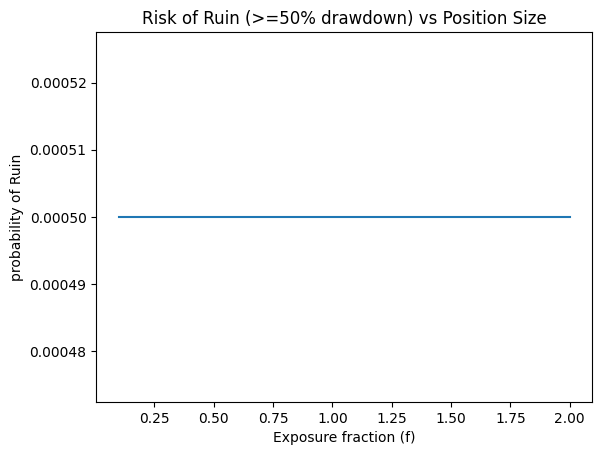

In [20]:
plt.figure()

plt.plot(fractions, ror)

plt.title("Risk of Ruin (>=50% drawdown) vs Position Size")

plt.xlabel("Exposure fraction (f)")

plt.ylabel("probability of Ruin")

plt.show()

Cell 7 (pick a "safe" sizing rule)

  - Example: choose the largest f with ruin ≤ 5%.

In [21]:
target = 0.05

safe_fs = [f for f, p in zip(fractions, ror) if p <= target]

safe_f = max(safe_fs) if safe_fs else None

safe_f

np.float64(2.0)

Show what a typical equity curve looks like at that f:

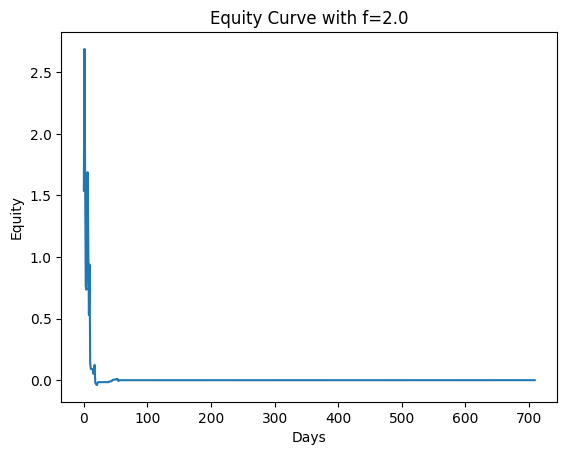

np.float64(-1.0143285959873487)

In [22]:
eq = equity_curve(r.values, f=safe_f)

plt.figure

plt.plot(eq)

plt.title(f"Equity Curve with f={safe_f:.2}")

plt.xlabel("Days")

plt.ylabel("Equity")

plt.show()

max_drawdown(eq)

## Day 7 - Risk of Ruin & Position Sizing

  - Even with positive EV strategies can fail due to volatility and sequence risk.
  - Position sizing controls surviva;; the same strategy can be safe or unsafe depending on exposure.
  - Risk of ruin analysis estimates the probability of sever drawdown across many possible sequences.
  - A sizing rule should be chosen based on acceptable dowside risk, not optimism.

  This framework is directly applicable to real trading systems.